In [41]:
# Librarys and Modules 

import pandas as pd 
import os
import copy
import statsmodels.api as sm
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error,root_mean_squared_error
from sklearn.metrics import r2_score
import optuna
import seaborn as sns
import pandas_ta as ta
import matplotlib.pyplot as plt
import yfinance as yf


In [42]:
codes_list = ['ZC=F']
dfs_list = []
for i in codes_list:
#for each code in codes list(all available contracts until end of 2026), I create a ticker element 
#pull the historical dataframe and append to a list
    i_ticker = yf.Ticker(i)

    i_df = i_ticker.history(period = 'max')
    print(i_df.head())
    dfs_list.append(i_df)


                             Open    High     Low   Close  Volume  Dividends  \
Date                                                                           
2000-07-17 00:00:00-04:00  182.25  182.25  178.25  179.25   19385        0.0   
2000-07-18 00:00:00-04:00  179.00  183.25  179.00  180.75   25205        0.0   
2000-07-19 00:00:00-04:00  180.00  182.75  178.75  182.00   17126        0.0   
2000-07-20 00:00:00-04:00  181.50  187.00  181.00  186.00   18742        0.0   
2000-07-21 00:00:00-04:00  185.50  188.00  185.00  187.75   16814        0.0   

                           Stock Splits  
Date                                     
2000-07-17 00:00:00-04:00           0.0  
2000-07-18 00:00:00-04:00           0.0  
2000-07-19 00:00:00-04:00           0.0  
2000-07-20 00:00:00-04:00           0.0  
2000-07-21 00:00:00-04:00           0.0  


In [43]:
vix_code = '^VIX'
vix_ticker= yf.Ticker(vix_code)

vix_df = vix_ticker.history(period='max')
vix_df.index = vix_df.index.date
print(vix_df.head())
vix_df['vix'] = vix_df['Close'] 


                 Open       High        Low      Close  Volume  Dividends  \
1990-01-02  17.240000  17.240000  17.240000  17.240000       0        0.0   
1990-01-03  18.190001  18.190001  18.190001  18.190001       0        0.0   
1990-01-04  19.219999  19.219999  19.219999  19.219999       0        0.0   
1990-01-05  20.110001  20.110001  20.110001  20.110001       0        0.0   
1990-01-08  20.260000  20.260000  20.260000  20.260000       0        0.0   

            Stock Splits  
1990-01-02           0.0  
1990-01-03           0.0  
1990-01-04           0.0  
1990-01-05           0.0  
1990-01-08           0.0  


In [44]:
dow_code = 'YM=F'
dow_ticker = yf.Ticker(dow_code)

dow_df = dow_ticker.history(period = 'max')
dow_df.index = dow_df.index.date
dow_df['dow'] = dow_df['Close']
print(dow_df.head())
#dow jones e-mini continous cbot contracts 
#not a lot of improvement in r^2 but maybe will be better in RF once we get interaction terms

               Open     High      Low    Close  Volume  Dividends  \
2002-04-05  10246.0  10340.0  10222.0  10290.0    4234        0.0   
2002-04-08  10277.0  10280.0  10105.0  10268.0    4407        0.0   
2002-04-09  10290.0  10311.0  10205.0  10222.0    6189        0.0   
2002-04-10  10229.0  10399.0  10215.0  10383.0    6372        0.0   
2002-04-11  10378.0  10378.0  10158.0  10170.0    5387        0.0   

            Stock Splits      dow  
2002-04-05           0.0  10290.0  
2002-04-08           0.0  10268.0  
2002-04-09           0.0  10222.0  
2002-04-10           0.0  10383.0  
2002-04-11           0.0  10170.0  


In [45]:
gold_code = 'GC=F'
gold_ticker = yf.Ticker(gold_code)

gold_df = gold_ticker.history(period = 'max')
gold_df.index = gold_df.index.date
gold_df['gold'] = gold_df['Close']
print(gold_df.head())

                  Open        High         Low       Close  Volume  Dividends  \
2000-08-30  273.899994  273.899994  273.899994  273.899994       0        0.0   
2000-08-31  274.799988  278.299988  274.799988  278.299988       0        0.0   
2000-09-01  277.000000  277.000000  277.000000  277.000000       0        0.0   
2000-09-05  275.799988  275.799988  275.799988  275.799988       2        0.0   
2000-09-06  274.200012  274.200012  274.200012  274.200012       0        0.0   

            Stock Splits        gold  
2000-08-30           0.0  273.899994  
2000-08-31           0.0  278.299988  
2000-09-01           0.0  277.000000  
2000-09-05           0.0  275.799988  
2000-09-06           0.0  274.200012  


In [46]:
crude_code = 'CL=F'
crude_ticker = yf.Ticker(crude_code)

crude_df = crude_ticker.history(period = 'max')
crude_df.index = crude_df.index.date
crude_df['crude'] = crude_df['Close']
#adds 2nd closest contract of crude oil futures 

In [47]:
soybean_code = 'ZS=F'
soybean_ticker = yf.Ticker(soybean_code)

soybean_df = soybean_ticker.history(period = 'max')
soybean_df.index = soybean_df.index.date
soybean_df['soybean'] = soybean_df['Close']
#adds 2nd closest contract of soybean futures (subst with corn)

In [48]:
# Variables 
for i, df in enumerate(dfs_list):    
    # Daily Returns
    df.index = df.index.date
    df['Returns'] = df['Close'].pct_change() * 100

    df['Month Returns'] = df['Close'].pct_change(periods = 28) * 100
    df['Month Returns'] = df['Month Returns'].shift(-28)

    #Relative Strength Index 
    df['Momentum RSI'] = ta.rsi(df['Close'], length=14)
    
    #Moving Average Convergence Divergence 
    macd = ta.macd(df['Close'], fast=12, slow=26, signal=9)
    df['MACD'] = macd['MACD_12_26_9']
    df['MACD_signal'] = macd['MACDs_12_26_9']
    df['MACD_diff'] = df['MACD'] - df['MACD_signal']
    
    #Bollinger bands 
    bollinger_bands = ta.bbands(df['Close'], length=20)
    #Setting up Upper, Middle, and Lower bands 
    df['Bollinger_upper'] = bollinger_bands['BBU_20_2.0']
    df['Bollinger_middle'] = bollinger_bands['BBM_20_2.0']
    df['Bollinger_lower'] = bollinger_bands['BBL_20_2.0']
    #Bollinger Position 
    df['Bollinger_position'] = (df['Close'] - df['Bollinger_middle']) / (df['Bollinger_upper'] - df['Bollinger_lower'])


    #On-Balance Volume 
    df['OBV'] = ta.obv(df['Close'], df['Volume'])

    #Stochastic Oscillator 
    stoch = ta.stoch(df['High'], df['Low'], df['Close'])
    df['%K'] = stoch['STOCHk_14_3_3']
    df['%D'] = stoch['STOCHd_14_3_3']

    #Volume Weighted Average Price
    df['VWAP'] = (df['Close'] * df['Volume']).cumsum() / df['Volume'].cumsum()

    df = pd.merge(df, vix_df['vix'], left_index=True, right_index=True)
    df = pd.merge(df, dow_df['dow'], left_index=True, right_index=True)
    df = pd.merge(df, gold_df['gold'], left_index=True, right_index=True)
    df = pd.merge(df, crude_df['crude'], left_index=True, right_index=True)
    df = pd.merge(df, soybean_df['soybean'], left_index=True, right_index=True)


    df = df.dropna()
    dfs_list[i] = df  # Assign the modified df back to the list
    print (df.head())

dfs_dct = dict(zip(codes_list, dfs_list))

              Open    High     Low   Close  Volume  Dividends  Stock Splits  \
2002-04-05  201.50  201.75  201.25  201.50     219        0.0           0.0   
2002-04-08  200.50  200.75  200.25  200.75     243        0.0           0.0   
2002-04-09  201.50  202.00  201.50  202.00     161        0.0           0.0   
2002-04-10  201.25  201.50  201.00  201.25     430        0.0           0.0   
2002-04-11  199.75  200.25  199.75  198.75     134        0.0           0.0   

             Returns  Month Returns  Momentum RSI  ...  Bollinger_position  \
2002-04-05  0.124224       7.320099     43.143701  ...           -0.372309   
2002-04-08 -0.372208       6.226650     41.496787  ...           -0.472034   
2002-04-09  0.622665       3.465347     45.248123  ...           -0.305825   
2002-04-10 -0.371287       5.093168     43.447961  ...           -0.365127   
2002-04-11 -1.242236       6.037736     38.018361  ...           -0.553398   

                OBV         %K   %D        VWAP        v

In [49]:
merged_df = dfs_list[0]

                            OLS Regression Results                            
Dep. Variable:          Month Returns   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     19.79
Date:                Thu, 20 Jun 2024   Prob (F-statistic):           2.32e-51
Time:                        15:25:44   Log-Likelihood:                -10143.
No. Observations:                2772   AIC:                         2.032e+04
Df Residuals:                    2756   BIC:                         2.041e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.8742      2

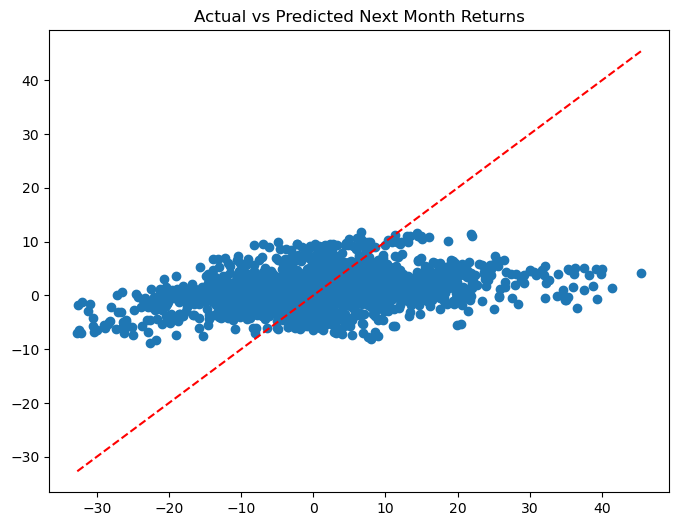

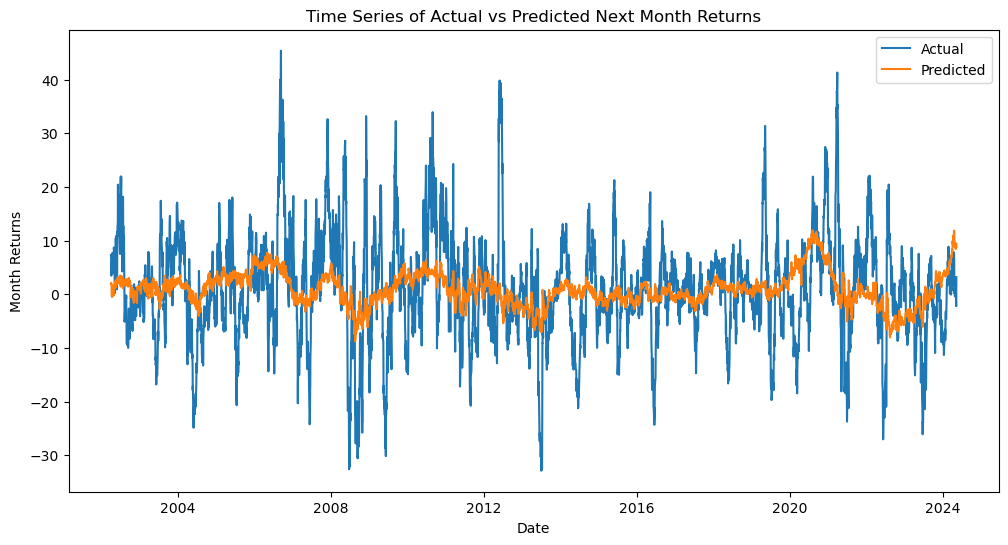

In [50]:
#OLS
    #Specifying Axes 
x_vars = ['Returns', 'Momentum RSI', 'Close','MACD','MACD_diff','Bollinger_position','OBV','%K','%D','VWAP','vix','dow','gold','crude','soybean']
X = merged_df.loc[:, x_vars] #Selecting only from merged_df
y = merged_df['Month Returns']
    
    #Training and Testing Data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
    
    # Add constant term to X_train and X_test
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
    
    # Fit the OLS model
model = sm.OLS(y_train, X_train).fit()
    
    # Make predictions on the test set
y_pred = model.predict(X_test) 
    
    #Model Evaluations 

    # Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Corrected function name
mse = mean_squared_error(y_test, y_pred)

    # Print model summary and evaluation metrics
print(model.summary())
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Squared Error(MSE): {mse:.2f}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
plt.title('Actual vs Predicted Next Month Returns')
plt.show()


X_full = sm.add_constant(X)
    # Make predictions on the entire dataset using the pre-trained model
y_pred_full = model.predict(X_full)
    
    # Plot actual vs predicted values over time
plt.figure(figsize=(12, 6))
plt.plot(merged_df.index, y, label='Actual')
plt.plot(merged_df.index, y_pred_full, label='Predicted')
plt.title('Time Series of Actual vs Predicted Next Month Returns')
plt.xlabel('Date')
plt.ylabel('Month Returns')
plt.legend()
plt.show()

In [51]:
#Objective function for grid search in Random Forest
#optuna intelligently grid searches across params in params{}
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    }

    rf_model = RandomForestRegressor(**params, random_state=42)

    # Train the model
    rf_model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = rf_model.predict(X_test)
    return mean_squared_error(y_test, y_pred)

In [52]:
# Visualization: Actual vs Predicted
'''
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()
'''

"\nplt.figure(figsize=(8, 6))\nplt.scatter(y_test, y_pred)\nplt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')\nplt.xlabel('Actual')\nplt.ylabel('Predicted')\nplt.title('Actual vs Predicted')\nplt.show()\n"

In [ ]:

# Set up Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

# Get the best hyperparameters
best_params = study.best_params

# Train the model with the best hyperparameters
rf_best = RandomForestRegressor(**best_params, random_state=42)
rf_best.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_best.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Best Hyperparameters: {best_params}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Squared Error(MSE): {mse:.2f}")

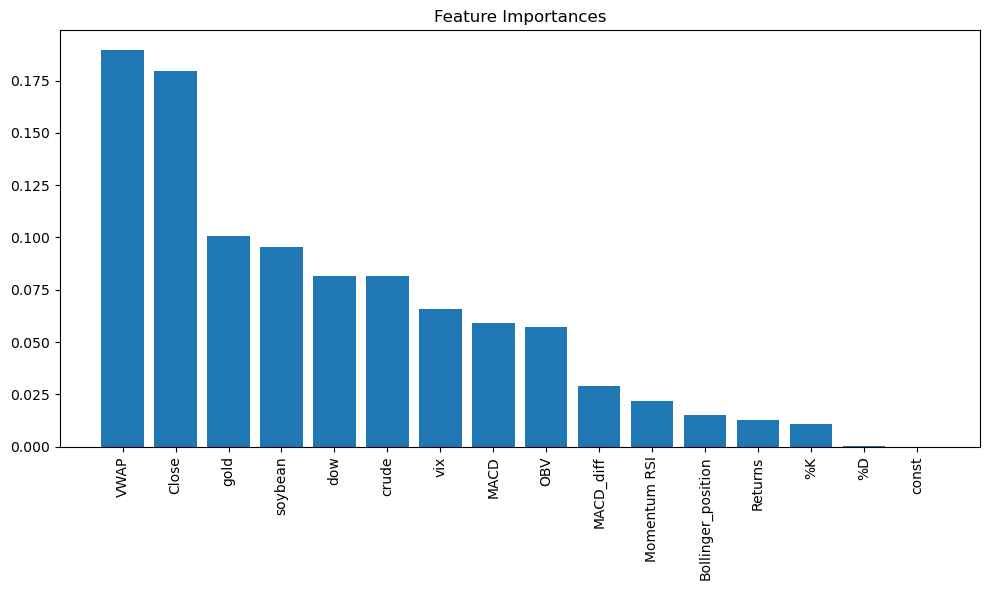

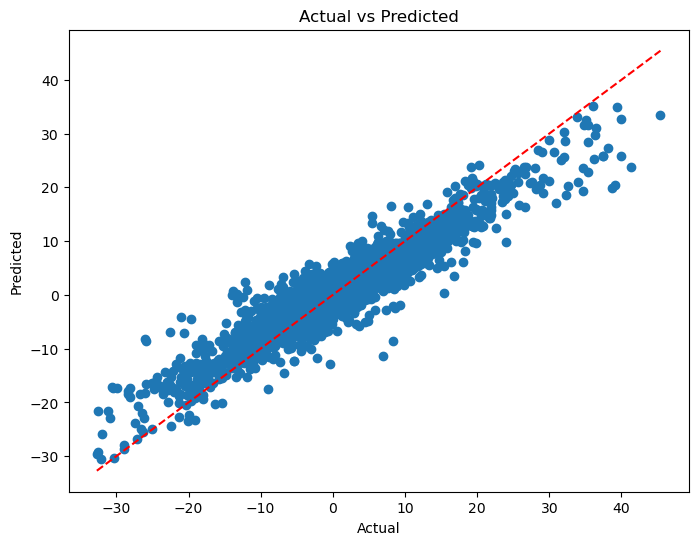

In [54]:

# Visualization: Feature Importance
feature_importances = rf_best.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), feature_importances[sorted_indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

# Visualization: Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

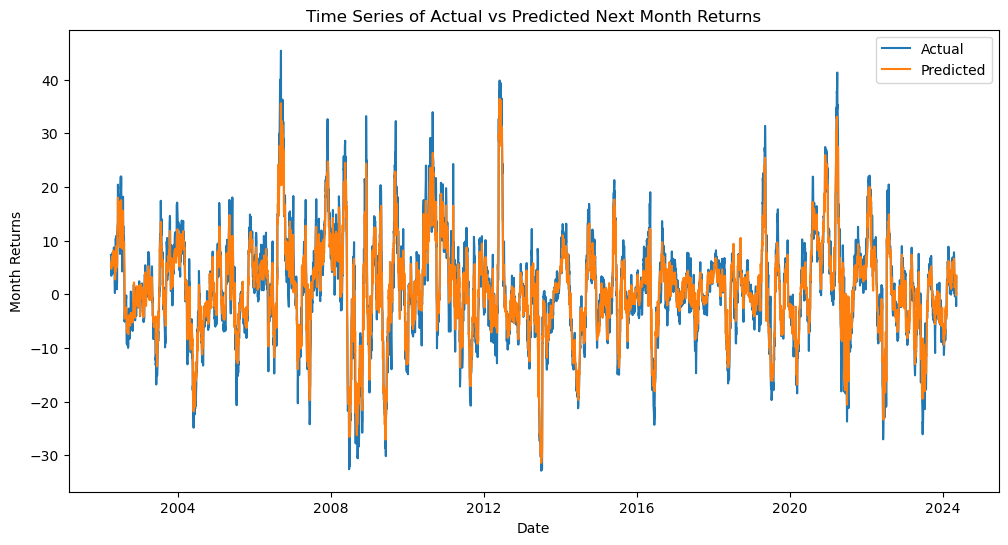

In [55]:
y_pred_full = rf_best.predict(X_full)

plt.figure(figsize=(12, 6))
plt.plot(merged_df.index, y, label='Actual')
plt.plot(merged_df.index, y_pred_full, label='Predicted')
plt.title('Time Series of Actual vs Predicted Next Month Returns')
plt.xlabel('Date')
plt.ylabel('Month Returns')
plt.legend()
plt.show()